In [11]:
import pandas as pd
import numpy as np


In [12]:
path = 'data\PurplePredict - 16 augustus 2023.xlsx'
df_raw = pd.read_excel(path)

In [13]:
def clean_data(df):
    
    # make a copy of the dataset
    df_temp = df.copy()
    
    # Define the relevant columns to analyze
    relevant_columns = [
    'Medewerker_code', 
    'Begindatum_contract', 
    'Einddatum_contract', 
    'Type_contract_omschrijving', 
    'Dienstbetrekking_omschrijving', 
    'Datum_in_dienst', 
    'Datum_uit_dienst',  
    'Status_dienstverband', 
    'Geboortedatum', 
    'Geslacht_omschrijving', 
    'AOW-datum', 
    'Ziektedagen_gewogen_va_2017', 
    'Aantal_ziekmeldingen_va_2017', 
    'Begindatum_functie', 
    'Einddatum_functie', 
    'Is_leidinggevende', 
    '#FULLTIME_SALARY'
    ]
    
    # selectthe relevant columns
    df_temp = df_raw.loc[:, relevant_columns]
    
    # Define Date Columns
    date_cols = [
        'Begindatum_contract',
        'Einddatum_contract',
        'Datum_in_dienst',
        'Datum_uit_dienst',
        'Geboortedatum',
        'AOW-datum',
        'Begindatum_functie',
        'Einddatum_functie'
        ]

    # Define Cateogric Columns
    categoric_columns = [
        'Type_contract_omschrijving',
        'Dienstbetrekking_omschrijving',
        'Status_dienstverband',
        'Geslacht_omschrijving',
        'Is_leidinggevende'
        ]

    # Change date columns to datetime 
    for column in date_cols:
        df_temp[column] = pd.to_datetime(df_temp[column], utc=True, errors='coerce').dt.tz_localize(None)
        #print(f"convertion of {column} is complete")

    # Change categoric columns to categoric type
    for column in categoric_columns:
        df_temp[column] = df_temp[column].astype('category')
        #print(f"convertion of {column} is complete")
    
    # Replace "-" values with Nan
    df_temp.replace("-", np.nan, inplace=True)
    
    # Drop duplicate employees
    df_temp = df_temp.drop_duplicates(subset=['Medewerker_code'], keep='last')
    
        # change irregular calues such as comma to decimal point and erase $ sign
    df_temp['#FULLTIME_SALARY'] = df_temp['#FULLTIME_SALARY'].str.replace('$', '').str.replace(',', '').astype('float')
    df_temp['Ziektedagen_gewogen_va_2017'] = df_temp['Ziektedagen_gewogen_va_2017'].str.replace(',', '.').astype('float')
    
    return df_temp
    
df_check = clean_data(df_raw)
df_check

C:\Users\baran\AppData\Local\Temp\ipykernel_21420\79645143.py:53: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_temp[column] = pd.to_datetime(df_temp[column], utc=True, errors='coerce').dt.tz_localize(None)
C:\Users\baran\AppData\Local\Temp\ipykernel_21420\79645143.py:53: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_temp[column] = pd.to_datetime(df_temp[column], utc=True, errors='coerce').dt.tz_localize(None)
C:\Users\baran\AppData\Local\Temp\ipykernel_21420\79645143.py:53: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_temp[column] = pd.to_datetime(df_temp[column]

,Medewerker_code,Begindatum_contract,Einddatum_contract,Type_contract_omschrijving,Dienstbetrekking_omschrijving,Datum_in_dienst,Datum_uit_dienst,Status_dienstverband,Geboortedatum,Geslacht_omschrijving,AOW-datum,Ziektedagen_gewogen_va_2017,Aantal_ziekmeldingen_va_2017,Begindatum_functie,Einddatum_functie,Is_leidinggevende,#FULLTIME_SALARY
0,6,2021-06-01,NaT,Onbepaalde tijd,Vaste medewerker,2018-11-01,NaT,In dienst,1961-09-22,Vrouw,2028-12-22,65.593000,4,2021-06-01,NaT,Niet Leidinggevende,3133.12
1,37,2020-10-01,NaT,Onbepaalde tijd,Vaste medewerker,2011-09-01,NaT,In dienst,1986-08-16,Vrouw,2053-11-16,130.683750,3,2020-10-01,NaT,Niet Leidinggevende,3133.12
2,47,2020-10-01,2021-09-30,Onbepaalde tijd,Parttimer,2011-09-01,2021-09-30,Uit dienst,1978-11-28,Vrouw,2046-02-28,95.026100,4,2020-10-01,2021-09-30,Niet Leidinggevende,2854.06
3,48,2020-10-01,NaT,Onbepaalde tijd,Vaste medewerker,2011-09-01,NaT,In dienst,1959-05-27,Vrouw,2026-05-27,42.670000,4,2020-10-01,NaT,Niet Leidinggevende,4282.63
4,61,2021-07-01,2023-07-31,Onbepaalde tijd,Vaste medewerker,2021-07-01,2023-07-31,In dienst,1972-09-15,Vrouw,2039-12-15,38.333983,5,2021-07-01,2023-07-31,Niet Leidinggevende,3133.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10302,9954390,2020-10-01,NaT,Onbepaalde tijd,Vaste medewerker,2017-08-01,NaT,In dienst,1960-04-06,Vrouw,2027-04-06,128.895200,13,2020-10-01,NaT,Niet Leidinggevende,3133.12
10303,9960950,1999-02-01,2017-04-30,Onbepaalde tijd,Parttimer,1999-02-01,2017-04-30,Uit dienst,1957-12-05,Vrouw,2024-12-05,0.000000,0,2017-02-01,2017-04-30,Niet Leidinggevende,2231.46
10304,9963310,2020-10-01,2021-01-31,Onbepaalde tijd,Parttimer,2017-08-01,2021-01-31,Uit dienst,1956-03-03,Vrouw,2022-10-03,22.858311,2,2020-10-01,2021-01-31,Niet Leidinggevende,2791.26
10305,9982140,2021-10-01,NaT,Onbepaalde tijd,Vaste medewerker,2021-03-01,NaT,In dienst,1963-01-25,Vrouw,2030-04-25,6.240000,2,2023-05-01,NaT,Niet Leidinggevende,3133.12


# feature engineering
Adjust necessary changes to `#FULLTIME_SALARY` column


In [14]:
def create_length_date(df):

    df_temp = df.copy()
    
    # Create Measurement Date
    measurement_date = '2023-07-01'
    measurement_date = pd.to_datetime(measurement_date)

    # Calculate employment lenght
    df_temp['tenure'] = np.where(
        df_temp['Datum_uit_dienst'].notna(),
        df_temp['Datum_uit_dienst'] - df_temp['Datum_in_dienst'],
        measurement_date - df_temp['Datum_in_dienst']
    )

    df_temp['functie_lengte'] = np.where(
        df_temp['Einddatum_functie'].notna(),
        df_temp['Einddatum_functie'] - df_temp['Begindatum_functie'],
        measurement_date - df_temp['Begindatum_functie']
    )

    df_temp['leeftijd'] = measurement_date - df_temp['Geboortedatum']

    df_temp['jaren_tot_aow'] = df_temp['AOW-datum'] - measurement_date

    # Convert tenure to number of days
    df_temp['tenure'] = df_temp['tenure'].dt.days / 365.25
    df_temp['functie_lengte'] = df_temp['functie_lengte'].dt.days / 365.25
    df_temp['leeftijd'] = df_temp['leeftijd'].dt.days / 365.25
    df_temp['jaren_tot_aow'] = df_temp['jaren_tot_aow'].dt.days / 365.25

    df_temp = df_temp.drop(columns=['Begindatum_contract', 'Einddatum_contract', 'Datum_uit_dienst', 'Datum_in_dienst', 'Einddatum_functie', 'Begindatum_functie', 'Geboortedatum', 'AOW-datum'])
    
    return df_temp

df_check = create_length_date(df_check)
df_check
    

,Medewerker_code,Type_contract_omschrijving,Dienstbetrekking_omschrijving,Status_dienstverband,Geslacht_omschrijving,Ziektedagen_gewogen_va_2017,Aantal_ziekmeldingen_va_2017,Is_leidinggevende,#FULLTIME_SALARY,tenure,functie_lengte,leeftijd,jaren_tot_aow
0,6,Onbepaalde tijd,Vaste medewerker,In dienst,Vrouw,65.593000,4,Niet Leidinggevende,3133.12,4.662560,2.080767,61.771389,5.478439
1,37,Onbepaalde tijd,Vaste medewerker,In dienst,Vrouw,130.683750,3,Niet Leidinggevende,3133.12,11.830253,2.746064,36.873374,30.379192
2,47,Onbepaalde tijd,Parttimer,Uit dienst,Vrouw,95.026100,4,Niet Leidinggevende,2854.06,10.080767,0.996578,44.588638,22.663929
3,48,Onbepaalde tijd,Vaste medewerker,In dienst,Vrouw,42.670000,4,Niet Leidinggevende,4282.63,11.830253,2.746064,64.095825,2.904860
4,61,Onbepaalde tijd,Vaste medewerker,In dienst,Vrouw,38.333983,5,Niet Leidinggevende,3133.12,2.080767,2.080767,50.789870,16.457221
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10302,9954390,Onbepaalde tijd,Vaste medewerker,In dienst,Vrouw,128.895200,13,Niet Leidinggevende,3133.12,5.913758,2.746064,63.233402,3.764545
10303,9960950,Onbepaalde tijd,Parttimer,Uit dienst,Vrouw,0.000000,0,Niet Leidinggevende,2231.46,18.242300,0.240931,65.568789,1.431896
10304,9963310,Onbepaalde tijd,Parttimer,Uit dienst,Vrouw,22.858311,2,Niet Leidinggevende,2791.26,3.501711,0.334018,67.326489,-0.741958
10305,9982140,Onbepaalde tijd,Vaste medewerker,In dienst,Vrouw,6.240000,2,Niet Leidinggevende,3133.12,2.332649,0.167009,60.429843,6.817248


In [15]:
df_check.isna().sum()

Medewerker_code                    0
Type_contract_omschrijving         0
Dienstbetrekking_omschrijving      0
Status_dienstverband               0
Geslacht_omschrijving              0
Ziektedagen_gewogen_va_2017        0
Aantal_ziekmeldingen_va_2017       0
Is_leidinggevende                  0
#FULLTIME_SALARY                 348
tenure                             0
functie_lengte                     0
leeftijd                           0
jaren_tot_aow                      0
dtype: int64

In [16]:
df_check['#FULLTIME_SALARY'] = df_check['#FULLTIME_SALARY'].fillna(df_check['#FULLTIME_SALARY']).mean()
df_check = df_check.rename(columns={'#FULLTIME_SALARY': 'Salary'})

In [17]:
categoric_columns = [
        'Type_contract_omschrijving',
        'Dienstbetrekking_omschrijving',
        'Status_dienstverband',
        'Geslacht_omschrijving',
        'Is_leidinggevende'
        ]

df_analysis = pd.get_dummies(df_check, columns=categoric_columns, drop_first=True)

df_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10297 entries, 0 to 10306
Data columns (total 26 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Medewerker_code                                 10297 non-null  int64  
 1   Ziektedagen_gewogen_va_2017                     10297 non-null  float64
 2   Aantal_ziekmeldingen_va_2017                    10297 non-null  int64  
 3   Salary                                          10297 non-null  float64
 4   tenure                                          10297 non-null  float64
 5   functie_lengte                                  10297 non-null  float64
 6   leeftijd                                        10297 non-null  float64
 7   jaren_tot_aow                                   10297 non-null  float64
 8   Type_contract_omschrijving_11 maanden contract  10297 non-null  bool   
 9   Type_contract_omschrijving_5 maandencontract

## Start of Analysis

In [18]:
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
from lifelines.utils import k_fold_cross_validation, find_best_parametric_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 


In [19]:
df_analysis_1 = df_analysis.copy()

In [20]:
low_variance_cols = ['Salary', 'Geslacht_omschrijving_Non-binair']
df_analysis_1 = df_analysis_1.drop(columns=low_variance_cols)


In [21]:
cph = CoxPHFitter()
cph.fit(df_analysis_1, duration_col = 'tenure', event_col = 'Status_dienstverband_Uit dienst')
cph.print_summary() 

<lifelines.CoxPHFitter: fitted with 10297 total observations, 5286 right-censored observations>
             duration col = 'tenure'
                event col = 'Status_dienstverband_Uit dienst'
      baseline estimation = breslow
   number of observations = 10297
number of events observed = 5011
   partial log-likelihood = -36538.45
         time fit was run = 2024-07-26 13:02:25 UTC

---
                                                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                       
Medewerker_code                                -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
Ziektedagen_gewogen_va_2017                    -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
Aantal_ziekmeldingen_va_2017                   -0.03      0.97      0.01           -0.04           -0.01                0.96                0.99
functie_lengte                                 -0.16      0.85      0.02           -0.20           -0.12                0.82                0.88
leeftijd                                        0.09      1.09      0.05           -0.02            0.19                0.98                1.21
jaren_tot_aow                                   0.11      1.11      0.05            0.00            0.21                1.00                1.23
Type_contract_omschrijving_11 maanden contract  0.45      1.57      0.21            0.04            0.87                1.04                2.38
Type_contract_omschrijving_5 maandencontract    0.79      2.20      0.22            0.35            1.22                1.42                3.39
Type_contract_omschrijving_7 maanden contract   1.08      2.96      0.18            0.73            1.43                2.08                4.19
Type_contract_omschrijving_8 maanden contract   0.37      1.44      0.24           -0.11            0.84                0.90                2.31
Type_contract_omschrijving_9 maanden contract  -0.07      0.93      0.25           -0.56            0.42                0.57                1.51
Type_contract_omschrijving_Anderhalf jaar      -0.06      0.94      0.35           -0.74            0.62                0.48                1.86
Type_contract_omschrijving_Bepaalde tijd        0.67      1.95      0.18            0.32            1.02                1.38                2.77
Type_contract_omschrijving_Halfjaarcontract     0.74      2.09      0.19            0.37            1.11                1.45                3.03
Type_contract_omschrijving_Jaarcontract         0.21      1.24      0.18           -0.13            0.56                0.88                1.75
Type_contract_omschrijving_Onbepaalde tijd     -1.30      0.27      0.18           -1.64           -0.95                0.19                0.39
Dienstbetrekking_omschrijving_Oproepkracht     -0.20      0.82      0.05           -0.31           -0.10                0.73                0.91
Dienstbetrekking_omschrijving_Parttimer         0.02      1.02      0.04           -0.05            0.09                0.95                1.09
Dienstbetrekking_omschrijving_Stagiair          0.71      2.03      0.72           -0.69            2.11                0.50                8.26
Dienstbetrekking_omschrijving_Vaste medewerker -4.35      0.01      0.14           -4.62           -4.09                0.01                0.02
Geslacht_omschrijving_Vrouw                    -0.11      0.90      0.04           -0.18           -0.03                0.83                0.97
Is_leidinggevende_Niet Leidinggevende          -0.06      0.94      0.06           -0.18            0.05                0.84                1.05

                                                cmp to      z      p  -log2(p)
covariate                                      

<Axes: xlabel='log(HR) (95% CI)'>

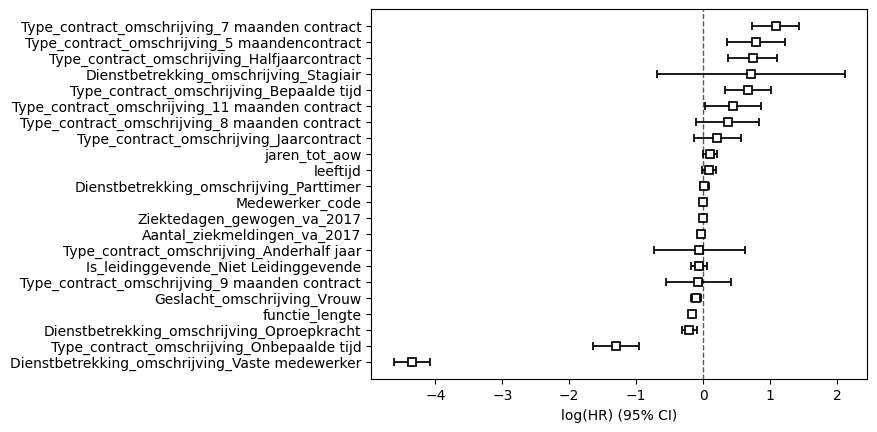

In [22]:
cph.plot()